In [23]:
import os
import re

from tqdm import tqdm
from natsort import natsorted

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import pdfplumber
import pytesseract
from langchain_community.document_loaders import (
    UnstructuredPDFLoader,
    PyMuPDFLoader,
)

import random
import torch
seed = 42
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

import warnings
warnings.filterwarnings('ignore')

In [7]:
data_path = "./data/card"
data_list = [data_path + "/" + path for path in natsorted(os.listdir(data_path))]

In [39]:
print(os.path.basename(data_list[0]))

0_iM Social Worker카드.pdf


In [40]:
pdf_open = pdfplumber.open(data_list[0])
pdf_pages = pdf_open.pages
pdf_pages

[<Page:1>, <Page:2>, <Page:3>, <Page:4>, <Page:5>, <Page:6>]

In [41]:
page_img = pdf_pages[0].to_image().original

In [42]:
page_img.height, page_img.width

(842, 596)

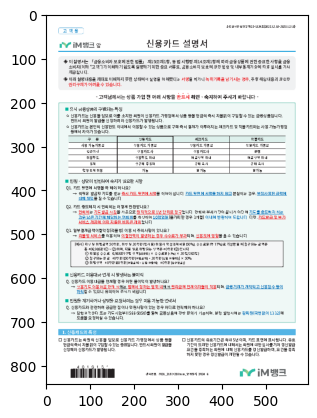

In [43]:
page_img_np = np.array(page_img)

plt.imshow(page_img_np)
plt.show()

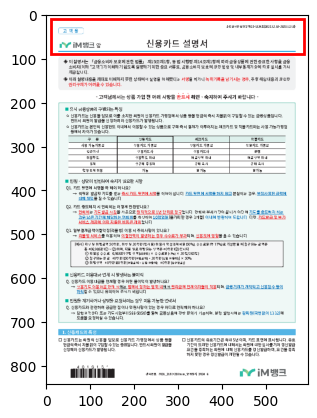

In [44]:
bbox = (10, 10, 586, 90)
x0, top, x1, bottom = bbox
width = x1 - x0
height = bottom - top

fig, ax = plt.subplots(1)
ax.imshow(page_img_np)

rect = patches.Rectangle((x0, top), width, height, linewidth=2, edgecolor='red', facecolor='none')
ax.add_patch(rect)

plt.show()

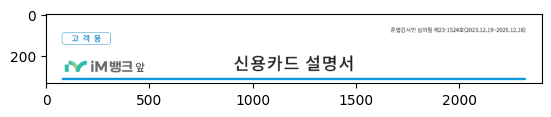

In [49]:
page = pdf_pages[0]
bbox = (10, 10, 586, 90)

page_crop = page.within_bbox(bbox=bbox)
page_crop_img = page_crop.to_image(resolution=300).original
page_crop_img_np = np.array(page_crop_img)

plt.imshow(page_crop_img_np)
plt.show()

In [51]:
# 크롭된 영역에서 텍스트 추출
extracted_text = page_crop.extract_text()

# 추출된 텍스트 출력
print(extracted_text)

준법감시인 심의필 제23-1524호(2023.12.19~2025.12.18)
고 객 용
앞


In [50]:
base_path = "./data/card"
base_name = os.path.basename(data_list[0]).split(".p")[0]
make_folder = f"{base_path}/{base_name}"
if not os.path.exists(make_folder):
    os.makedirs(make_folder)
num = 0
plt.imsave(f"{make_folder}/{num}.png", page_crop_img_np)